# **1. Data Loading**

In [198]:
# enable importing nflmodels package
import sys
sys.path.append('..') 


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, cohen_kappa_score, roc_auc_score, mean_squared_error, log_loss, RocCurveDisplay, f1_score

import xgboost as xgb

import seaborn as sns
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

from joblib import dump, load

# DEV: reload modules
import importlib
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
importlib.reload(sys.modules.get('nflmodels.dataloading', sys))
importlib.reload(sys.modules.get('nflmodels.models', sys))
importlib.reload(sys.modules.get('nflmodels.validation', sys))

from nflmodels.preprocessing import preprocess_next_play, preprocess_field_goal, preprocess_ep
from nflmodels.dataloading import load_data_postgresql
from nflmodels.models import FieldGoalModel, NextPlayModel, EPModel
from nflmodels.validation import valplot_fieldgoal, valplot_nextplay, valplot_ep

In [199]:
df = load_data_postgresql(min_season=2010, max_season=2022, verbose=False, cols=['qb_hit', 'sack', 'penalty_player_name', 'penalty_type', 'passer_player_name', 'qb_hit_1_player_name', 'qb_hit_2_player_name', 
                          'sack_player_name', 'half_sack_1_player_name', 'half_sack_2_player_name',])

c:\Users\Eemeli\Documents\GitHub\nflmodels\notebooks\..\nflmodels\dataloading.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql=query, con=conn)


# **2. Play Type Prediction - ML**

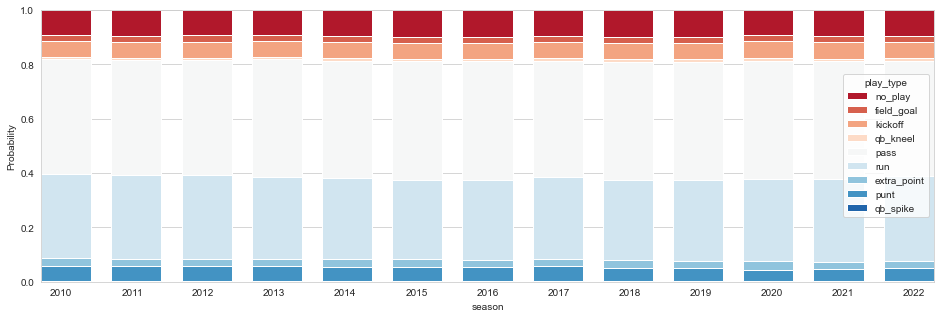

In [3]:
# plot play types per season
fig, ax = plt.subplots(figsize=(16,5))
sns.histplot(data=df, x='season', hue='play_type', stat='probability', multiple='fill', shrink=5, palette='RdBu', ax=ax, alpha=1)
ax.set_xticks([*range(df['season'].min(), df['season'].max() + 1, 1)])
plt.show()

Play types are distributed similarly in all seasons featured here.

In [5]:
# # preliminary testing shows that weighting only increased the errors in past seasons, does not really influence performance on recent data
# USE_SAMPLE_WEIGHTS = False

# if USE_SAMPLE_WEIGHTS:
#     # create sample weights
#     df_plays['sample_weights'] = 1

#     n_of_seasons = df_plays['season'].max() - df_plays['season'].min() + 1

#     for i in range(n_of_seasons):
#         season = df_plays['season'].max() - i
#         #sample_weights['sample_weights'] = np.where(sample_weights['season'] == season, 1 / n_of_seasons * (n_of_seasons - i), sample_weights['sample_weights'])
#         # if i < 3:
#         df_plays['sample_weights'] = np.where(df_plays['season'] == season,  5 / (n_of_seasons ** 2) * ((n_of_seasons - i) ** 2), df_plays['sample_weights'])
#         # else:
#         #     sample_weights['sample_weights'] = np.where(sample_weights['season'] == season,  1 / 169 * ((n_of_seasons - i) * (n_of_seasons - i)), sample_weights['sample_weights'])
# else:
#     df_plays['sample_weights'] = 1


In [6]:
# subquery_args = [
# #    'season >= 2022',
# #    'posteam == "KC"'
# ]

# subquery = ' and '.join(subquery_args)

# # Feature selection --------------------

# features = [
#     'sample_weights',
#     #'posteam_score', 
#     #'defteam_score', 
#     'score_differential', 
#     'qtr', 
#     'game_seconds_remaining', 
#     'half_seconds_remaining', 
#     'down', 
#     'yardline_100', 
#     'ydstogo', 
#     'goal_to_go', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     'posteam_type', 
#     'shotgun',
#     #'posteam',
#     #'defteam',
#     ]

# if subquery == '':
#     y = df_plays['play_type']
#     X = df_plays[features]
# else:
#     y = df_plays.query(subquery)['play_type']
#     X = df_plays.query(subquery)[features]

# # Feature engineering ------------------

# # - encode categoricals
# X = pd.get_dummies(X, columns=[
#     'qtr', 
#     'down', 
#     'posteam_timeouts_remaining', 
#     'defteam_timeouts_remaining', 
#     #'posteam',
#     #'defteam',
#     ])

# sample_weights = X['sample_weights'].to_numpy()
# X.drop('sample_weights', axis=1, inplace=True)

### Train-val-test

In [4]:
X, y, labels = preprocess_next_play(data=df, seasons=[], return_X_y=True, map_target_to_int=True, include_fg=True, include_qbkneel=False, include_qbspike=False, verbose=True)

# split train_val_test 60-20-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)

Preprocessing 631166 rows...
Preprocessing for play types: ['pass', 'run', 'field_goal', 'punt']
Dropped 1263 rows containing NaN values.
Resulting dataset size is 485179 rows.
Encoding play types as integers...
Returned preprocessed X, y, play_types


### XGBClassifier

On validation set
ROC AUC: 0.850
F1 score: 0.750
MSE: 0.260
Log loss: 0.497


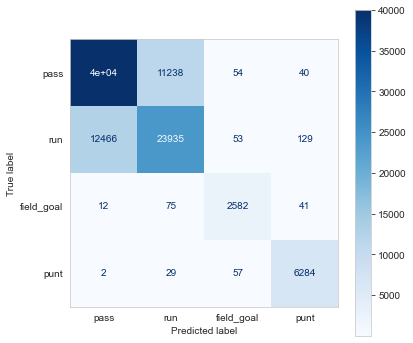

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     51371
           1       0.68      0.65      0.67     36583
           2       0.94      0.95      0.95      2710
           3       0.97      0.99      0.98      6372

    accuracy                           0.75     97036
   macro avg       0.84      0.84      0.84     97036
weighted avg       0.75      0.75      0.75     97036

Cohen kappa score: 0.563


In [5]:
model = NextPlayModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)
valplot_nextplay(X_val, y_val, y_pred, y_pred_proba, labels=labels)

# **3. Field Goal Success Prediction - ML**

### Preprocess & Train test split

In [6]:
X, y = preprocess_field_goal(data=df, kickers='active', return_X_y=True)

# Split train-val-test: 70%/12.5%/12.5%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

### Model training

On validation set
ROC AUC: 0.788
MSE: 0.095
Log loss: 0.264


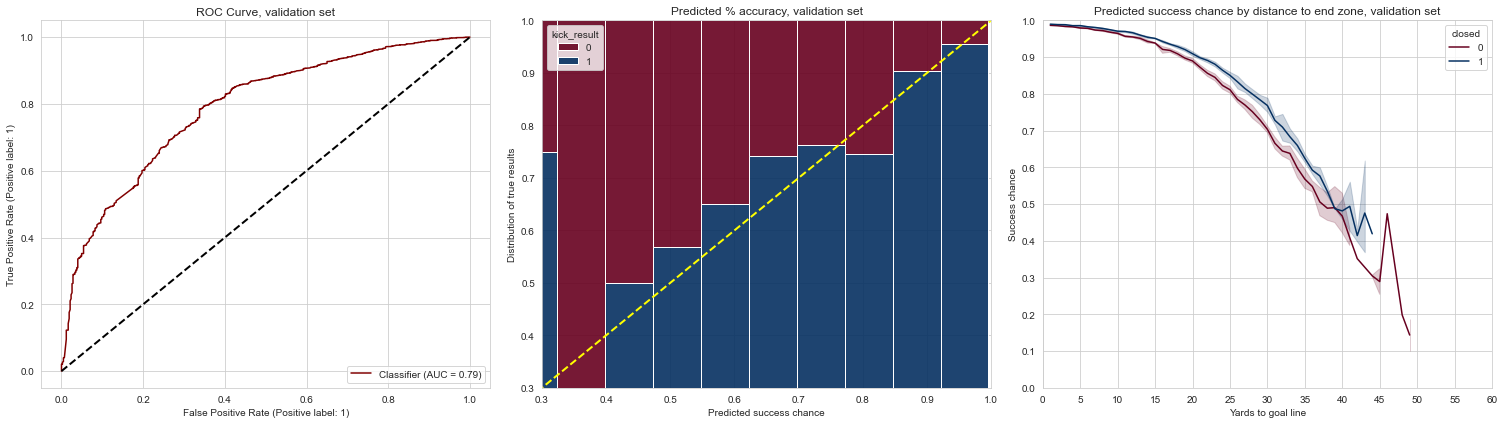

In [7]:
model = FieldGoalModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)
valplot_fieldgoal(X_val, y_val, y_pred, y_pred_proba)

In [8]:
# 1. Retrain using train + val
# 2. Test on test set
# 3. Save model using joblib

model_fg = FieldGoalModel()
model_fg.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))

# Predict on test set
y_pred, y_pred_proba = model_fg.validate(X_test, y_test)

# Save model to disk
#dump(clf_fg, 'clf_fg.joblib')
#print('Model saved!')
#load('clf_fg.joblib') # to load saved model

On validation set
ROC AUC: 0.791
MSE: 0.091
Log loss: 0.256


### Using the Model

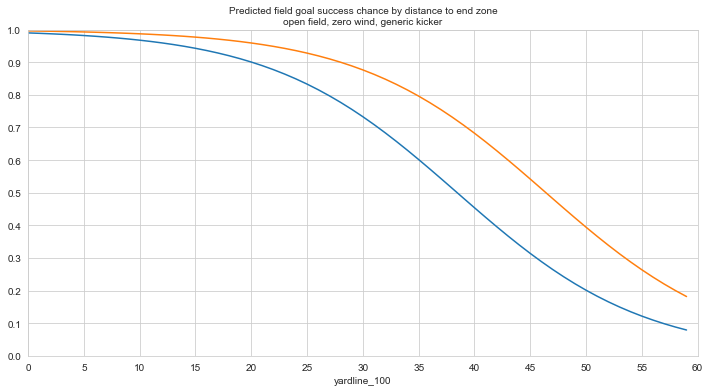

In [12]:
# simulated kicks, open air field, no wind, generic kicker
ydline = [*range(0, 60, 1)]
pred_df = pd.DataFrame({'yardline_100': ydline})
for i in range(1, len(clf.feature_names_in_)): #start from 1 to skip yardline
    pred_df[clf.feature_names_in_[i]] = 0
pred_df['kicker_player_name_Other'] = 1 #use other player for all predictions
#pred_df['closed'] = 1
#pred_df['wind'] = 15

pred_res = clf.predict_proba(pred_df)[:,1]#.reshape(-1, 1)

# J.Tucker
pred_df['kicker_player_name_Other'] = 0
pred_df['kicker_player_name_J.Tucker'] = 1
pred_res_jt = clf.predict_proba(pred_df)[:,1]

# plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res)
sns.lineplot(ax=ax, data=pred_df, x='yardline_100', y=pred_res_jt)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
ax.set_ylim(0, 1)
ax.set_xlim(0, 60)
ax.set_title('Predicted field goal success chance by distance to end zone\nopen field, zero wind, generic kicker', size=10)
plt.show()

# **4. EP & EPA**

ep = expected points

In [9]:
df.info()
# [['game_id', 'play_id', 'qtr', 'game_half', 'posteam', 'defteam', 'drive', 'down', 'yardline_100', 'play_type', 
#                               'penalty', 'timeout', 'sp', 'posteam_score', 'defteam_score', 'play_score_gained', 'next_score', 'ep', 'epa']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631166 entries, 0 to 631165
Data columns (total 83 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     631166 non-null  int64  
 1   game_id                     631166 non-null  object 
 2   home_team                   631166 non-null  object 
 3   away_team                   631166 non-null  object 
 4   posteam                     585011 non-null  object 
 5   posteam_type                585011 non-null  object 
 6   defteam                     585011 non-null  object 
 7   yardline_100                578432 non-null  float64
 8   quarter_seconds_remaining   630612 non-null  float64
 9   half_seconds_remaining      630612 non-null  float64
 10  game_seconds_remaining      630612 non-null  float64
 11  quarter_end                 631166 non-null  int64  
 12  drive                       621437 non-null  float64
 13  sp            

In [10]:
# TODO: temp, remove after not needed
importlib.reload(sys.modules.get('nflmodels.preprocessing', sys))
from nflmodels.preprocessing import preprocess_ep

X_n, y_n, X_pat, y_pat = preprocess_ep(data=df)

Preprocessing 631166 rows...
After dropping some rows, dataset size is 578032
All 578032 out of 578032 rows processed!
Final dataset size is 578009 rows


In [7]:
# Split train-val-test: 70%/12.5%/12.5%
X_train, X_val, y_train, y_val = train_test_split(X_n, y_n, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [8]:
model = EPModel()
model.fit(X_train, y_train)
y_pred, y_pred_proba = model.validate(X_val, y_val)

c:\Users\Eemeli\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


On validation set


ValueError: could not convert string to float: 'opp_td'

In [9]:
y_pred = model.classifier.predict(X_val)
y_pred_proba = model.classifier.predict_proba(X_val)

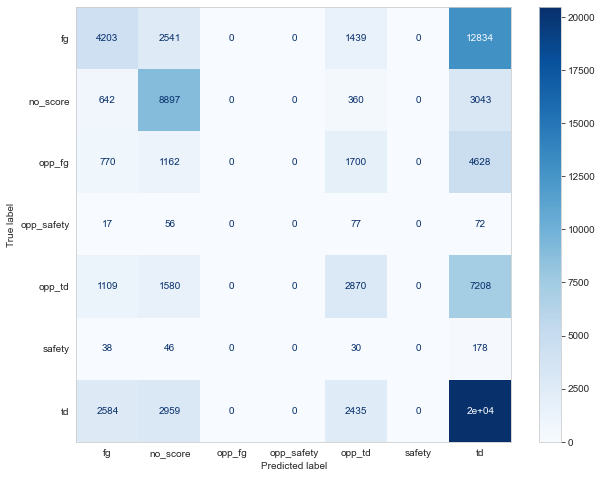

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax, cmap='Blues')
ax.grid(False)
plt.show()

### Temp Notes:

In [61]:
#df_ep.query('extra_point_attempt == 0 and two_point_attempt == 0')['next_score'].value_counts()
df_ep['next_score'].value_counts()

td            187904
fg            140240
no_score       87539
opp_td         85234
opp_fg         55300
safety          1933
opp_safety      1500
Name: next_score, dtype: int64

In [62]:
df_pat['next_score'].value_counts()

pat              16156
no_score          1321
2pat               696
opp_patreturn       11
Name: next_score, dtype: int64

In [56]:
df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1')['next_score'].value_counts()

pat              15959
no_score          1321
2pat               623
opp_patreturn       11
Name: next_score, dtype: int64

In [55]:
df_ep['next_score_value'].value_counts()

 6    187904
 3    140240
 0     88860
-6     85234
-3     55300
 1     16156
 2      2629
-2      1511
Name: next_score_value, dtype: int64

In [22]:
df_ep.query('field_goal_attempt == 1')[['next_score','sp','yardline_100', 'play_score_gained','ep','epa', 'play_type']].head(60)

,next_score,sp,yardline_100,play_score_gained,ep,epa,play_type
13,opp_fg,0,16.0,None,2.690119,-4.517740,field_goal
40,fg,1,4.0,3.0,2.937339,0.062661,field_goal
63,fg,1,28.0,3.0,1.932867,1.067133,field_goal
108,fg,1,7.0,3.0,2.890051,0.109949,field_goal
192,fg,1,34.0,3.0,0.835992,2.164008,field_goal
245,fg,0,28.0,None,1.843330,-3.219873,field_goal
253,opp_fg,0,37.0,None,1.155874,-1.864610,field_goal
257,fg,1,31.0,3.0,1.994863,1.005137,field_goal
272,fg,1,21.0,3.0,2.336894,0.663106,field_goal
280,fg,1,18.0,3.0,2.410303,0.589697,field_goal


One possibility would be to assess extra point attempts differently and obtain a reasonable expectation on the value. Then this value would be used with tds to increase their value and drop extra point attempts completely...?

Issues:
nflverse says that the value of a touchdown is always seven, meaning that on a td ep+epa=7

In [23]:
#df_ep.query('game_id == "2022_18_TEN_JAX"').groupby('posteam')['epa'].sum()
df_ep.query('season == 2022 and play_score_gained == 3')[['ep', 'epa']].head(30)

,ep,epa
533297,2.948091,0.051909
533342,2.193322,0.806678
533479,2.222366,0.777634
533507,1.772887,1.227113
533666,2.921587,0.078413
533685,2.723580,0.276420
533720,2.608476,0.391524
533741,2.734776,0.265224
533749,1.204142,1.795858
533771,2.842867,0.157133


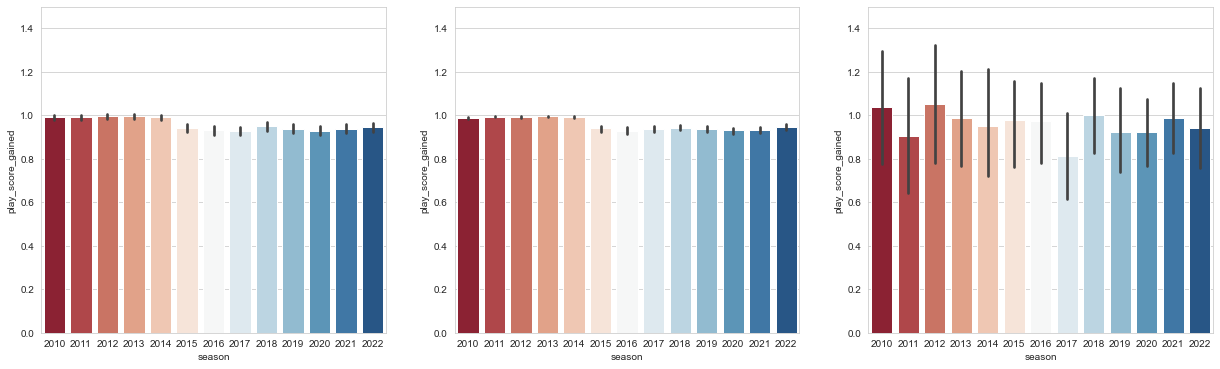

In [30]:
#df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1')['play_score_gained'].mean()
fig, ax = plt.subplots(1, 3, figsize=(21, 6))
sns.barplot(data=df_ep.query('extra_point_attempt == 1 or two_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[0], palette='RdBu')
ax[0].set_ylim(0, 1.5)
sns.barplot(data=df_ep.query('extra_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[1], palette='RdBu')
ax[1].set_ylim(0, 1.5)
sns.barplot(data=df_ep.query('two_point_attempt == 1'), x='season', y='play_score_gained', ax=ax[2], palette='RdBu')
ax[2].set_ylim(0, 1.5)
plt.show()

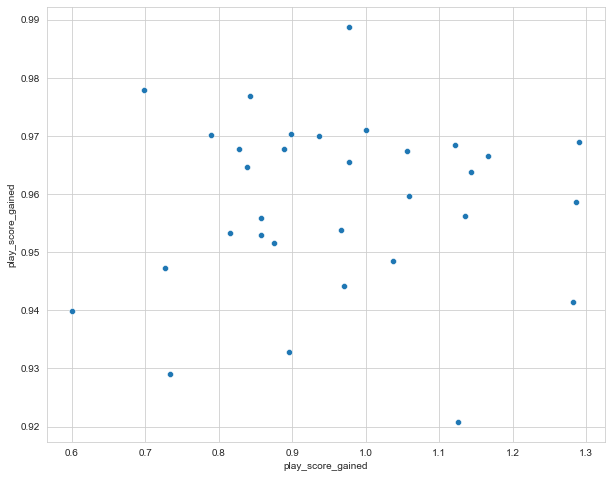

In [49]:
#df_ep.query('extra_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean()
#df_ep.query('two_point_attempt == 1 and season >= 2021').groupby(by='posteam')['play_score_gained'].mean()
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(
    y=df_ep.query('extra_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean(), 
    x=df_ep.query('two_point_attempt == 1').groupby(by='posteam')['play_score_gained'].mean(),
    #hue=df_ep['posteam'].unique()
)
plt.show()

# **RTP Analysis**

In [200]:
df_rtp = df.copy()
df_rtp['rtp'] = np.where(df_rtp['penalty_type'] == "Roughing the Passer", 1, 0)
df_rtp['hit'] = np.where((df_rtp['qb_hit'] == 1) | (df_rtp['sack'] == 1), 1, 0)

In [201]:
df_rtp['rtp'].value_counts()

0    630453
1      1405
Name: rtp, dtype: int64

In [202]:
seasons = [2022]

t = df_rtp.query('season in @seasons').groupby(by='posteam')[['rtp', 'hit']].agg('sum')#.reset_index()
t['ratio'] = t['rtp'] / t['hit']
t.sort_values(by='ratio', ascending=True, inplace=True)
t.reset_index(inplace=True)

t2 = df_rtp.query('season in @seasons').groupby(by='defteam')[['rtp', 'hit']].agg('sum')#.reset_index()
t2['ratio'] = t2['rtp'] / t2['hit']
t2.sort_values(by='ratio', ascending=False, inplace=True)
t2.reset_index(inplace=True)

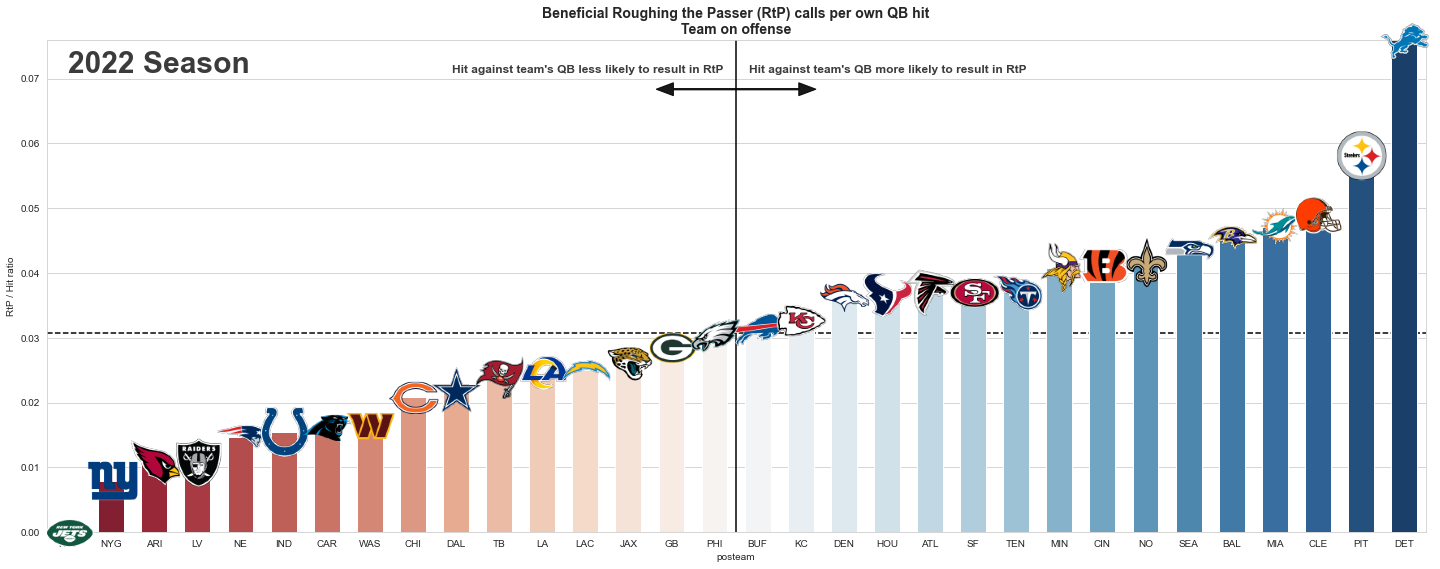

In [203]:
import requests
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

data = t

fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(ax=ax, data=data, x='posteam', y='ratio', palette='RdBu', width=0.6)
ax.set_title('Beneficial Roughing the Passer (RtP) calls per own QB hit\nTeam on offense', fontsize=14, fontweight=600)
ax.set_ylabel('RtP / Hit ratio')
ax.set_yticks(np.arange(0,1,0.01))

# logos
for index, row in data.iterrows():
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{row["posteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.8)
    ab = AnnotationBbox(img, (index, row['ratio']), frameon=False)
    ax.add_artist(ab)

# median line
ax.axhline(y=data['ratio'].median(), linestyle='--', color='black', zorder=0)
# median vline
ax.axvline(x=len(data)/2-0.5, linestyle='-', color='black')


# add season text
ax.text(0, data['ratio'].max() - (data['ratio'].max() / 15), '2022 Season', fontsize=30, fontweight=600, alpha=0.9)

# arrows and explanation texts
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=-len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.2,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against team's QB more likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.8,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against team's QB less likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9, ha='right')

# set axis limits
ax.set_ylim(0,data['ratio'].max())
ax.set_xlim(0-0.5, len(data)-0.5)

plt.tight_layout()
plt.show()

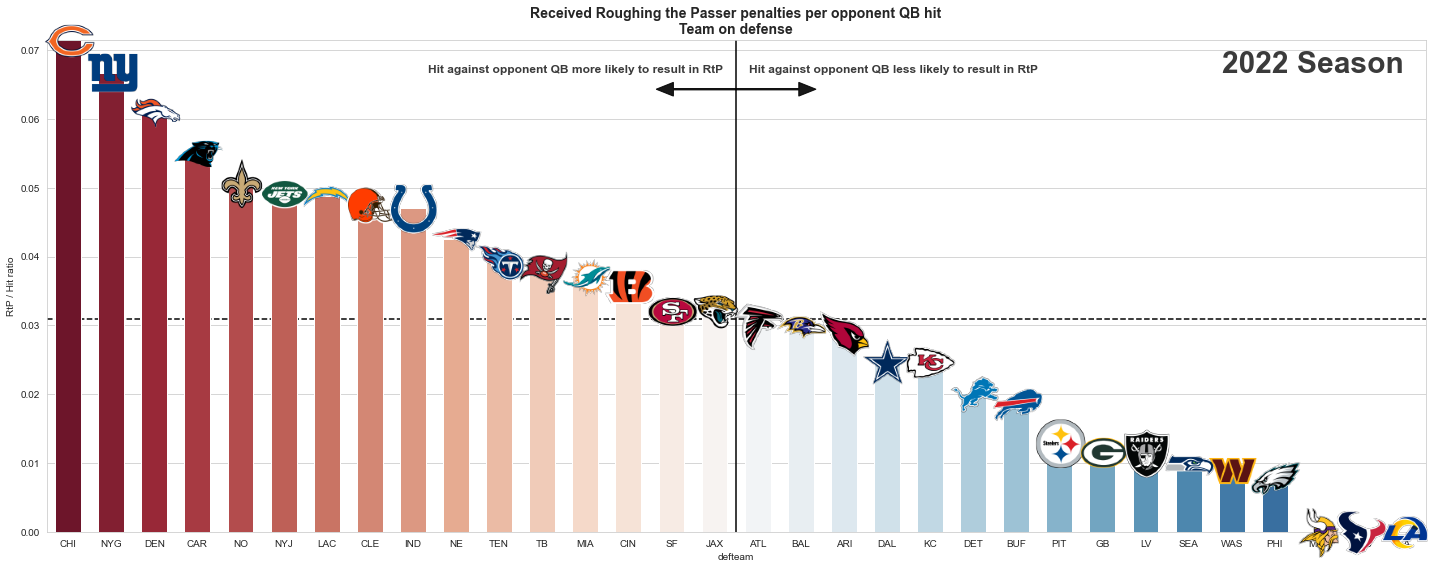

In [204]:
data=t2

fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(ax=ax, data=data, x='defteam', y='ratio', palette='RdBu', width=0.6)
ax.set_title('Received Roughing the Passer penalties per opponent QB hit\nTeam on defense', fontsize=14, fontweight=600)
ax.set_ylabel('RtP / Hit ratio')
ax.set_yticks(np.arange(0,1,0.01))

# logos
for index, row in data.iterrows():
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{row["defteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.8)
    ab = AnnotationBbox(img, (index, row['ratio']), frameon=False)
    ax.add_artist(ab)

# median line
ax.axhline(y=data['ratio'].median(), linestyle='--', color='black', zorder=0)
# median vline
ax.axvline(x=len(data)/2-0.5, linestyle='-', color='black')

# add season text
ax.text(len(data)-1, data['ratio'].max() - (data['ratio'].max() / 15), '2022 Season', fontsize=30, fontweight=600, alpha=0.9, ha='right')

# arrows and explanation texts
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.arrow(x = len(data) / 2 - 0.5, y = data['ratio'].max() - (data['ratio'].max() / 10), dx=-len(data)/22, dy=0, width=0.0002, head_width=0.002, head_length=0.4, color='black', alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.2,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against opponent QB less likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9)
ax.text(
    x=len(data) / 2 - 0.8,
    y=data['ratio'].max() - (data['ratio'].max() / 15),
    s="Hit against opponent QB more likely to result in RtP", fontsize=12, fontweight=600, alpha=0.9, ha='right')

# set axis limits
ax.set_ylim(0,data['ratio'].max())
ax.set_xlim(0-0.5, len(data)-0.5)

plt.tight_layout()
plt.show()

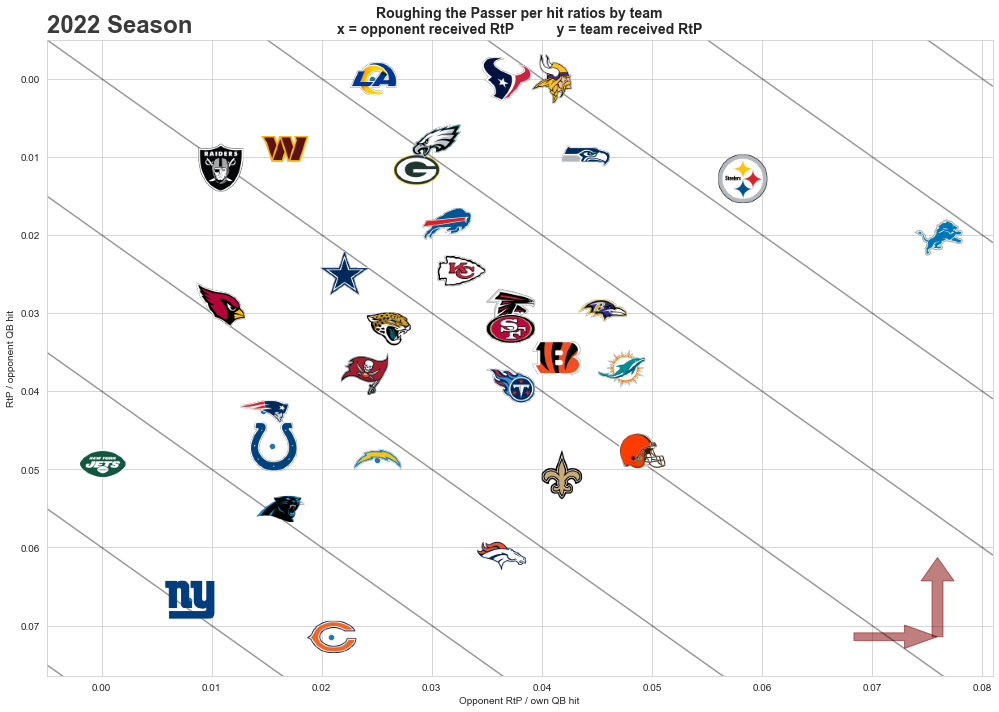

In [205]:
# scatter
x_data = t.sort_values(by='posteam').reset_index()
y_data = t2.sort_values(by='defteam').reset_index()

fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(x=x_data['ratio'], y=y_data['ratio'], ax=ax)
ax.set_ylabel('RtP / opponent QB hit')
ax.set_xlabel('Opponent RtP / own QB hit')
ax.set_title('Roughing the Passer per hit ratios by team\nx = opponent received RtP           y = team received RtP', fontsize=14, fontweight=600)

for i in range(len(x_data)):
    response = requests.get(f'https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/{x_data.iloc[i]["posteam"].lower()}.png&h=64&w=64')
    img = OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.8)
    ab = AnnotationBbox(img, (x_data.iloc[i]['ratio'], y_data.iloc[i]['ratio']), frameon=False)
    ax.add_artist(ab)

# add season text
ax.text(-0.005, data['ratio'].min() - 0.006, '2022 Season', fontsize=24, fontweight=600, alpha=0.9)

# set axis limits, invert y
ax.set_xlim(-0.005, x_data['ratio'].max()+0.005)
ax.set_ylim(-0.005, y_data['ratio'].max()+0.005)
ax.invert_yaxis()
    
# abline
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black', alpha=0.4)

for i in np.arange(-0.12, 0.12, 0.02):
    abline(1, i)
    
# add arrows
ax.arrow(x=x_data['ratio'].max()-x_data['ratio'].max()/10, y=y_data['ratio'].max(), 
         dx=x_data['ratio'].max()/10-0.003, dy=0, head_length=0.003, color='maroon', alpha=0.5)
ax.arrow(x=x_data['ratio'].max(), y=y_data['ratio'].max(), 
         dx=0, dy=-y_data['ratio'].max()/10, head_length=0.003, color='maroon', alpha=0.5)

plt.tight_layout()
plt.show()

In [47]:
qbs = [
    'T.Huntley', 'L.Jackson',
    'J.Allen', 'J.Burrow',
    'D.Watson', 'R.Wilson',
    'D.Mills', 'J.Driskel',
    'S.Ehlinger', 'M.Ryan',
    'T.Lawrence', 'P.Mahomes',
    'J.Stidham', 'J.Herbert',
    'S.Thompson', 'T.Tagovailoa',
    'M.Jones', 'M.White',
    'K.Pickett', 'J.Dobbs',
    'R.Tannehill', 'D.Ridder',
    'D.Blough', 'K.Murray',
    'S.Darnold', 'N.Peterman',
    'J.Fields', 'D.Prescott',
    'J.Goff', 'A.Rodgers',
    'B.Mayfield', 'M.Stafford',
    'K.Cousins', 'A.Dalton',
    'D.Jones', 'J.Hurts',
    'B.Purdy', 'T.Lance',
    'J.Garoppolo', 'G.Smith',
    'T.Brady', 'S.Howell'
]

df_rtp = df.query('(qb_hit == 1 or sack == 1) and passer_player_name in @qbs').copy() # plays where qb was hit
len(df_rtp)
# ideas: include spreads? are underdogs favored

14302

In [48]:
df_rtp['rtp'] = np.where(df_rtp['penalty_type'] == "Roughing the Passer", 1, 0)

In [49]:
df_rtp['rtp'].value_counts()

0    14181
1      121
Name: rtp, dtype: int64

In [50]:
print('rtp per hit')
df_rtp.groupby('passer_player_name')['rtp'].agg(['count', 'sum', 'mean']).reset_index().sort_values(by='mean', ascending=False)[0:60]

rtp per hit


,passer_player_name,count,sum,mean
11,J.Allen,420,9,0.021429
4,D.Blough,47,1,0.021277
7,D.Prescott,527,8,0.015180
21,K.Cousins,829,11,0.013269
0,A.Dalton,637,8,0.012559
27,M.Stafford,968,11,0.011364
24,L.Jackson,264,3,0.011364
26,M.Ryan,1335,15,0.011236
30,P.Mahomes,483,5,0.010352
16,J.Garoppolo,291,3,0.010309


In [20]:
df_rtp['rtp'] = np.where(df_rtp['penalty_type'] == "Roughing the Passer", 1, 0)

M.Ryan        1335
R.Wilson      1215
T.Brady       1109
M.Stafford     968
A.Rodgers      935
              ... 
C.Lamb           1
J.Charlton       1
T.Bray           1
G.Tate           1
J.Maclin         1
Name: passer_player_name, Length: 308, dtype: int64

In [55]:
len(df.query('penalty_type == "Roughing the Passer"'))

1404

In [56]:
len(df.query('penalty_type == "Roughing the Passer" and (sack == 1 or qb_hit == 1)'))

374

In [62]:
df.query('penalty_type == "Roughing the Passer"')['penalty_team']

,penalty_team,penalty_team,penalty_team
141,NYG,NYG,NYG
166,PHI,PHI,PHI
212,NYG,NYG,NYG
1161,JAX,JAX,JAX
1349,LA,LA,LA
...,...,...,...
630746,MIN,MIN,MIN
630775,KC,KC,KC
630832,KC,KC,KC
630934,MIA,MIA,MIA


In [63]:
df.query('penalty_type == "Roughing the Passer" and (sack == 0 and qb_hit == 0)').head(40)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,game_half,down,goal_to_go,yrdln,ydstogo,ydsnet,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,posteam_timeouts_remaining,defteam_timeouts_remaining,timeout,timeout_team,td_team,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,ep,epa,wp,def_wp,home_wp,away_wp,wpa,penalty,safety,interception,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,complete_pass,penalty_team,penalty_yards,season,drive_ended_with_score,away_score,home_score,game_stadium,roof,surface,weather,wind,temp,kicker_player_name,qb_hit,sack,penalty_team,penalty_player_name,penalty_type,passer_player_name,qb_hit,sack,penalty_team,penalty_player_name,penalty_type,passer_player_name,qb_hit_1_player_name,qb_hit_2_player_name,sack_player_name,half_sack_1_player_name,half_sack_2_player_name,qb_hit,sack,penalty_player_name,penalty_type,passer_player_name,qb_hit_1_player_name,qb_hit_2_player_name,sack_player_name,half_sack_1_player_name,half_sack_2_player_name
166,1384,2015_06_NYG_PHI,PHI,NYG,NYG,away,PHI,71.0,709.0,709.0,2509.0,0,8.0,0,2,Half1,2.0,0,NYG 29,1,42.0,pass,9.0,1,1,1.0,0,0,0,short,right,6.0,3.0,None,None,None,NaN,None,None,2.0,3.0,0.0,None,None,7.0,14.0,-7.0,7.0,14.0,-7.0,1.205793,1.373852,0.242603,0.757397,0.757397,0.242603,0.027474,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PHI,15.0,2015,0.0,7,27,Lincoln Financial Field,outdoors,grass,"Clear Temp: 44° F, Humidity: 49%, Wind: SSW 6 mph",6.0,44.0,None,0.0,0.0,PHI,C.Thornton,Roughing the Passer,E.Manning,0.0,0.0,PHI,C.Thornton,Roughing the Passer,E.Manning,None,None,None,None,None,0.0,0.0,C.Thornton,Roughing the Passer,E.Manning,None,None,None,None,None
212,2448,2015_06_NYG_PHI,PHI,NYG,PHI,home,NYG,19.0,19.0,19.0,1819.0,0,15.0,0,2,Half1,2.0,0,NYG 19,10,47.0,no_play,0.0,1,1,0.0,0,0,0,None,None,NaN,NaN,None,None,None,NaN,None,None,2.0,0.0,0.0,None,None,14.0,7.0,7.0,14.0,7.0,7.0,2.676009,0.770767,0.874684,0.125316,0.874684,0.125316,0.012946,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NYG,10.0,2015,1.0,7,27,Lincoln Financial Field,outdoors,grass,"Clear Temp: 44° F, Humidity: 49%, Wind: SSW 6 mph",6.0,44.0,None,0.0,0.0,NYG,C.Jenkins,Roughing the Passer,None,0.0,0.0,NYG,C.Jenkins,Roughing the Passer,None,None,None,None,None,None,0.0,0.0,C.Jenkins,Roughing the Passer,None,None,None,None,None,None
1161,3444,2015_07_BUF_JAX,JAX,BUF,BUF,away,JAX,41.0,729.0,729.0,729.0,0,18.0,0,4,Half2,3.0,0,JAX 41,7,56.0,no_play,0.0,1,0,0.0,0,0,0,None,None,NaN,NaN,None,None,None,NaN,None,None,3.0,2.0,0.0,None,None,16.0,27.0,-11.0,16.0,27.0,-11.0,1.840239,2.222462,0.101340,0.898660,0.898660,0.101340,0.049110,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JAX,15.0,2015,0.0,31,34,Wembley Stadium,outdoors,grass,"Sunny Intervals Temp: 48° F, Humidity: 74%, Wi...",2.0,48.0,None,0.0,0.0,JAX,A.Branch,Roughing the Passer,None,0.0,0.0,JAX,A.Branch,Roughing the Passer,None,None,None,None,None,None,0.0,0.0,A.Branch,Roughing the Passer,None,None,None,None,None,None
1349,3047,2015_07_CLE_STL,LA,CLE,CLE,away,LA,77.0,753.0,753.0,753.0,0,20.0,0,4,Half2,2.0,0,CLE 23,8,30.0,no_play,0.0,1,0,0.0,0,0,0,None,None,NaN,NaN,None,None,None,NaN,None,None,3.0,3.0,0.0,None,None,6.0,17.0,-11.0,6.0,17.0,-11.0,0.197019,1.486569,0.080472,0.919528,0.919528,0.080472,0.037433,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LA,15.0,2015,0.0,6,24,Edward Jones Dome,dome,astroplay,"Temp: ° F, Wind: mph",NaN,NaN,None,0.0,0.0,LA,N.Fairley,Roughing the Passer,None,0.0,0.0,LA,N.Fairley,Roughing the Passer,None,None,None,None,None,None,0.0,0.0,N.Fairley,